# Getting SEC filings from the EDGAR service

All companies and securities are required to submit quarterly 10-Q forms and an annual 10-K. These forms are public information, held by the SEC and accessible by the Electronic Data Gathering, Analysis, and Retriever system.

SEC filings are the main source of fundamental information for a company. They are especially easy to access since the eXtensible Business Reporting Language (XBRL) came around.

You can manually search for company filings at this website:
https://www.sec.gov/edgar/searchedgar/companysearch.html


In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
# imported in order of use
from pathlib import Path
import pandas as pd

from tqdm import tqdm

import requests
from urllib.request import urlopen
from zipfile import ZipFile, BadZipFile
from io import BytesIO

import json
from pprint import pprint

import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker

In [3]:
# make data path
sec_path = Path('../../data/sec_data')

# set URLs
sec_url = 'https://www.sec.gov'
fsn_path = 'files/dera/data/financial-statement-and-notes-data-sets/'

# make the filing periods
filing_periods = [(d.year, d.quarter) for d in pd.date_range('2015', '2020-12-31', freq='Q')]
filing_periods

[(2015, 1),
 (2015, 2),
 (2015, 3),
 (2015, 4),
 (2016, 1),
 (2016, 2),
 (2016, 3),
 (2016, 4),
 (2017, 1),
 (2017, 2),
 (2017, 3),
 (2017, 4),
 (2018, 1),
 (2018, 2),
 (2018, 3),
 (2018, 4),
 (2019, 1),
 (2019, 2),
 (2019, 3),
 (2019, 4),
 (2020, 1),
 (2020, 2),
 (2020, 3),
 (2020, 4)]

In [ ]:
# make the loop that downloads all the data
for yr, qr in tqdm(filing_periods):
  
  # make the directory
  path = sec_path / f'{yr}_{qr}' / 'source'
  if not path.exists():
    path.mkdir(parents=True)

  # define the url
  filing_url = f'{yr}q{qr}_notes.zip'
  whole_url = sec_url + '/' + fsn_path + filing_url

  # get file from url and then unzip it
  try:
    with urlopen(whole_url) as zipresp:
      with ZipFile(BytesIO(zipresp.read())) as zfile:
        for file in zfile.namelist():
          local_file = path / file
          if local_file.exists():
            continue
          with local_file.open('wb') as output_file:
            for line in zfile.open(file).readlines():
              output_file.write(line)

  except BadZipFile:
    print(f'\nBad Zip File: {yr} {qr}\n')
    continue

  0%|          | 0/24 [00:00<?, ?it/s]

## Speeding up Data Access

Now that we've got the data, we need to be able to read it all into Python.

It is pretty large, and in text-based tsv files, too, so opening it all up will take a while. Instead, we are going to convert them to binary parquet files. Then we can read them in much more quickly.

Parquet is a very fast filetype for all kinds of data, but excels at mixed data, such as text. HDF5 is much faster at both reading and writing numerical data, but parquet is faster with text. It also has the smallest file size for mixed data.

In [ ]:
# loop through all of the tsv files in the sec_data folder
for file in tqdm(list(sec_path.glob('**/*.tsv'))):

  # make separate directory for parquet files
  parquet_path = file.parent.parent / 'parquet'
  if not parquet_path.exists():
    parquet_path.mkdir(parents=True)

  # change files to parquet
  parquet_name = file.stem + '.parquet'
  if not (parquet_path / parquet_name).exists():
    try:
      # on this next line, the encoding='latin1' bypasses codecs lookup to make this faster
      df = pd.read_csv(file, sep='\t', encoding='latin1', low_memory=False, error_bad_lines=False)
      df.to_parquet(parquet_path / parquet_name)
    except Exception as e:
      print(e, ' [from] ', file)
      # now delete the .tsv file, to free up space
    else:
      file.unlink()

# Metadata Files

If you look through the 'source' folders, you will see that each one has a metadata file in json format. We are now going to parse those.

Let's look at one of those files now.

In [ ]:
# just get the first one.
yr = 2015
qr = 1
json_file = sec_path / f'{yr}_{qr}' / 'source' / f'{yr}q{qr}_notes-metadata.json'

with json_file.open() as js:
  metadata_sample = json.load(js)
pprint(metadata_sample)

{'@context': 'http://www.w3.org/ns/csvw',
 'dialect': {'delimiter': '\t', 'header': True, 'headerRowCount': 1},
 'tables': [{'tableSchema': {'aboutUrl': 'readme.htm',
                             'columns': [{'datatype': {'base': 'string',
                                                       'maxLength': 20,
                                                       'minLength': 20},
                                          'dc:description': 'Accession Number. '
                                                            'The 20-character '
                                                            'string formed '
                                                            'from the 18-digit '
                                                            'number assigned '
                                                            'by the Commission '
                                                            'to each EDGAR '
                                                           

# Data Organization

Each quarter, the data comes as 8 file sets:

* **SUB** - Submission - Identifies the company, form, date, and so on
* **TAG** - Tag - Explains the taxonomy tags
* **DIM** - Dimension - Addition details for numeric and text data
* **NUM** - Numeric - One row for each distinct data point in the filing
* **TXT** - Text - All the text fields
* **REN** - Rendering - Used to render on the SEC website
* **PRE** - Presentation - More details
* **CAL**- Calculation - Shows how different tags are calculated

Right now, we are only going to care about the sub, num, and maybe text files.

# Submission Info



In [ ]:
sub_data = pd.read_parquet(sec_path / '2020_4' / 'parquet' / 'sub.parquet')
sub_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16113 entries, 0 to 16112
Data columns (total 40 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   adsh         16113 non-null  object 
 1   cik          16113 non-null  int64  
 2   name         16113 non-null  object 
 3   sic          16109 non-null  float64
 4   countryba    16086 non-null  object 
 5   stprba       15162 non-null  object 
 6   cityba       16086 non-null  object 
 7   zipba        16077 non-null  object 
 8   bas1         16086 non-null  object 
 9   bas2         6684 non-null   object 
 10  baph         16096 non-null  object 
 11  countryma    16027 non-null  object 
 12  stprma       15181 non-null  object 
 13  cityma       16028 non-null  object 
 14  zipma        16016 non-null  object 
 15  mas1         16021 non-null  object 
 16  mas2         6594 non-null   object 
 17  countryinc   14696 non-null  object 
 18  stprinc      13979 non-null  object 
 19  ein 

There were over 16,000 filings in the 4th quarter of 2020! But how many *uniquely named* filings were there?

Only about 5850.

In [ ]:
# get the number of unique companies (by name) 
print('Unique Names: ', sub_data['name'].unique().shape[0])

Unique Names:  5845


# Get the filings for Charles Schwab

We will use Charles Schwab, since I recently interviewed with them.

In [ ]:
sub_data['name'].unique()[31:40]

array(['SCHWAB CHARLES CORP', 'PG&E CORP', 'GLOBAL ARENA HOLDING, INC.',
       'LUVU BRANDS, INC.', 'PENSKE AUTOMOTIVE GROUP, INC.',
       'W. P. CAREY INC.', 'ALEXANDRIA REAL ESTATE EQUITIES, INC.',
       'COSTAR GROUP, INC.', 'CUMULUS MEDIA INC'], dtype=object)

In [ ]:
company_name = 'SCHWAB CHARLES CORP'
schwab = sub_data[sub_data['name'] == company_name].T.dropna().squeeze()
important_columns = ['name', 'adsh', 'cik', 'sic', 'countryba', 'stprba',
                     'cityba', 'zipba', 'bas1', 'form', 'period', 'filed']
schwab.loc[important_columns]

,34,522,1310,8240,13262,14300
name,SCHWAB CHARLES CORP,SCHWAB CHARLES CORP,SCHWAB CHARLES CORP,SCHWAB CHARLES CORP,SCHWAB CHARLES CORP,SCHWAB CHARLES CORP
adsh,0000950103-20-019329,0000950103-20-019743,0000316709-20-000050,0000316709-20-000054,0000316709-20-000058,0001193125-20-315965
cik,316709,316709,316709,316709,316709,316709
sic,6211,6211,6211,6211,6211,6211
countryba,US,US,US,US,US,US
stprba,CA,CA,CA,CA,CA,CA
cityba,SAN FRANCISCO,SAN FRANCISCO,SAN FRANCISCO,SAN FRANCISCO,SAN FRANCISCO,SAN FRANCISCO
zipba,94105,94105,94105,94105,94105,94105
bas1,211 MAIN STREET,211 MAIN STREET,211 MAIN STREET,211 MAIN STREET,211 MAIN STREET,211 MAIN STREET
form,8-K,8-K,8-K,10-Q,8-K/A,8-K


Schwab has had a big year, and as such they filed a bunch of 8-K forms in addition to 10-Q.

But we are really interested in the 10-Q forms, because we are going to build a time series of a few fundamental metrics.

# Build Charles Schwab Fundamentals Time Series

To get this information over time, we need to comb through all of the sub.parquet files and pull out the 10-K and 10-Q forms.

We will use the Central Index Key to make sure we are getting filings from the right place.

In [ ]:
schwab_submissions = pd.DataFrame()
for sub in sec_path.glob('**/sub.parquet'):
  temp_sub = pd.read_parquet(sub)
  schwab_sub = temp_sub[(temp_sub['cik'].astype(int) == schwab.loc['cik'].values[0]) & (temp_sub['form'].isin(['10-Q', '10-K']))]
  schwab_submissions = pd.concat([schwab_submissions, schwab_sub])



0it [00:00, ?it/s]

2it [00:00, 17.56it/s]

4it [00:00, 15.95it/s]

6it [00:00, 16.06it/s]

8it [00:00, 15.02it/s]

10it [00:00, 15.12it/s]

12it [00:00, 14.86it/s]

14it [00:00, 14.85it/s]

16it [00:01, 14.72it/s]

18it [00:01, 14.60it/s]

20it [00:01, 13.62it/s]

22it [00:01, 14.22it/s]

24it [00:01, 14.29it/s]


In [ ]:
schwab_submissions['form'].value_counts()

10-Q    18
10-K     6
Name: form, dtype: int64

In [ ]:
schwab_submissions.head()

,adsh,cik,name,sic,countryba,stprba,cityba,zipba,bas1,bas2,baph,countryma,stprma,cityma,zipma,mas1,mas2,countryinc,stprinc,ein,former,changed,afs,wksi,fye,form,period,fy,fp,filed,accepted,prevrpt,detail,instance,nciks,aciks,pubfloatusd,floatdate,floataxis,floatmems
2266,0000316709-15-000014,316709,SCHWAB CHARLES CORP,6211.0,US,CA,SAN FRANCISCO,94105,211 MAIN STREET,None,415-667-7000,US,CA,SAN FRANCISCO,94105,211 MAIN STREET,None,US,DE,943025021.0,None,NaN,1-LAF,1,1231.0,10-K,20141231.0,2014.0,FY,20150223,2015-02-23 16:35:00.0,0,1,schw-20141231.xml,1,None,3.070000e+10,20140630.0,None,NaN
2163,0000316709-17-000010,316709,SCHWAB CHARLES CORP,6211.0,US,CA,SAN FRANCISCO,94105,211 MAIN STREET,None,415-667-7000,US,CA,SAN FRANCISCO,94105,211 MAIN STREET,None,US,DE,943025021.0,None,NaN,1-LAF,1,1231.0,10-K,20161231.0,2016.0,FY,20170223,2017-02-23 17:23:00.0,0,1,schw-20161231.xml,1,None,2.970000e+10,20160630.0,None,NaN
2407,0000316709-17-000061,316709,SCHWAB CHARLES CORP,6211.0,US,CA,SAN FRANCISCO,94105,211 MAIN STREET,None,415-667-7000,US,CA,SAN FRANCISCO,94105,211 MAIN STREET,None,US,DE,943025021.0,None,NaN,1-LAF,0,1231.0,10-Q,20170930.0,2017.0,Q3,20171107,2017-11-07 16:35:00.0,0,1,schw-20170930.xml,1,None,NaN,NaN,None,NaN
7581,0000316709-20-000021,316709,SCHWAB CHARLES CORP,6211.0,US,CA,SAN FRANCISCO,94105,211 MAIN STREET,None,415-667-7000,US,CA,SAN FRANCISCO,94105,211 MAIN STREET,None,US,DE,943025021.0,None,NaN,1-LAF,0,1231.0,10-Q,20200331.0,2020.0,Q1,20200508,2020-05-08 16:50:00.0,0,1,schw-03312020x10q_htm.xml,1,None,NaN,NaN,None,NaN
2097,0000316709-15-000056,316709,SCHWAB CHARLES CORP,6211.0,US,CA,SAN FRANCISCO,94105,211 MAIN STREET,None,415-667-7000,US,CA,SAN FRANCISCO,94105,211 MAIN STREET,None,US,DE,943025021.0,None,NaN,1-LAF,0,1231.0,10-Q,20150930.0,2015.0,Q3,20151105,2015-11-05 16:28:00.0,0,1,schw-20150930.xml,1,None,NaN,NaN,None,NaN


## Getting Numerical Data

So...now we want to go through the parquet files and pull out the numerical information we want.

In [ ]:
# start by looking at an example
pd.read_parquet(sec_path / '2015_1' / 'parquet' / 'num.parquet').head()

,adsh,tag,version,ddate,qtrs,uom,dimh,iprx,value,footnote,footlen,dimn,coreg,durp,datp,dcml
0,0000002178-15-000014,AccountsPayableCurrent,us-gaap/2014,20131231,0,USD,0x00000000,0,266099000.0,None,0,0,None,0.0,0.0,-3
1,0000002178-15-000014,AccountsPayableCurrent,us-gaap/2014,20141231,0,USD,0x00000000,0,160743000.0,None,0,0,None,0.0,0.0,-3
2,0000006281-15-000005,AccountsPayableCurrent,us-gaap/2014,20141031,0,USD,0x00000000,0,138967000.0,None,0,0,None,0.0,-1.0,-3
3,0000006281-15-000005,AccountsPayableCurrent,us-gaap/2014,20150131,0,USD,0x00000000,0,123456000.0,None,0,0,None,0.0,0.0,-3
4,0000006845-15-000003,AccountsPayableCurrent,us-gaap/2014,20140228,0,USD,0x00000000,0,47241000.0,None,0,0,None,0.0,-1.0,-3


So we need to match filings by adsh.

In [ ]:
schwab_numeric = pd.DataFrame()
for num in sec_path.glob('**/num.parquet'):
  temp_num = pd.read_parquet(num)
  schwab_num = temp_num[temp_num['adsh'].isin(schwab_submissions['adsh'])]
  # check to make sure we get a reasonable number
  print(len(schwab_num))
  schwab_numeric = pd.concat([schwab_numeric, schwab_num])




0it [00:00, ?it/s]

1it [00:06,  6.72s/it]

1900




2it [00:15,  7.47s/it]

2173




3it [00:21,  6.82s/it]

1906




4it [00:27,  6.65s/it]

1976




5it [00:33,  6.49s/it]

1235




6it [00:39,  6.31s/it]

1215




7it [00:45,  6.07s/it]

1880




8it [00:51,  6.21s/it]

2279




9it [00:57,  6.01s/it]

2028




10it [01:05,  6.73s/it]

1971




11it [01:10,  6.35s/it]

1707




12it [01:19,  6.97s/it]

2561




13it [01:26,  6.89s/it]

1819




14it [01:31,  6.57s/it]

1183




15it [01:37,  6.40s/it]

1408




16it [01:43,  6.07s/it]

1352




17it [01:48,  5.94s/it]

1020




18it [01:57,  6.81s/it]

2543




19it [02:06,  7.55s/it]

2722




20it [02:13,  7.21s/it]

2385




21it [02:19,  6.86s/it]

2285




22it [02:25,  6.50s/it]

2032




23it [02:31,  6.48s/it]

2415




24it [02:38,  6.59s/it]

1857


In [ ]:
schwab_numeric.head()

,adsh,tag,version,ddate,qtrs,uom,dimh,iprx,value,footnote,footlen,dimn,coreg,durp,datp,dcml
3557203,0000316709-15-000014,AccumulatedDepreciationDepletionAndAmortizatio...,us-gaap/2014,20131231,0,USD,0x00000000,0,1.790000e+09,None,0,0,None,0.0,0.0,-6
3557204,0000316709-15-000014,AccumulatedDepreciationDepletionAndAmortizatio...,us-gaap/2014,20141231,0,USD,0x00000000,0,1.890000e+09,None,0,0,None,0.0,0.0,-6
3560722,0000316709-15-000014,AdditionalPaidInCapital,us-gaap/2014,20131231,0,USD,0x00000000,0,3.951000e+09,None,0,0,None,0.0,0.0,-6
3560723,0000316709-15-000014,AdditionalPaidInCapital,us-gaap/2014,20141231,0,USD,0x00000000,0,4.050000e+09,None,0,0,None,0.0,0.0,-6
3573964,0000316709-15-000014,Assets,us-gaap/2014,20131231,0,USD,0x00000000,0,1.436420e+11,None,0,0,None,0.0,0.0,-6


In [ ]:
schwab_numeric['ddate'] = pd.to_datetime(schwab_numeric['ddate'], format="%Y%m%d")
schwab_numeric.head()

,adsh,tag,version,ddate,qtrs,uom,dimh,iprx,value,footnote,footlen,dimn,coreg,durp,datp,dcml
3557203,0000316709-15-000014,AccumulatedDepreciationDepletionAndAmortizatio...,us-gaap/2014,2013-12-31,0,USD,0x00000000,0,1.790000e+09,None,0,0,None,0.0,0.0,-6
3557204,0000316709-15-000014,AccumulatedDepreciationDepletionAndAmortizatio...,us-gaap/2014,2014-12-31,0,USD,0x00000000,0,1.890000e+09,None,0,0,None,0.0,0.0,-6
3560722,0000316709-15-000014,AdditionalPaidInCapital,us-gaap/2014,2013-12-31,0,USD,0x00000000,0,3.951000e+09,None,0,0,None,0.0,0.0,-6
3560723,0000316709-15-000014,AdditionalPaidInCapital,us-gaap/2014,2014-12-31,0,USD,0x00000000,0,4.050000e+09,None,0,0,None,0.0,0.0,-6
3573964,0000316709-15-000014,Assets,us-gaap/2014,2013-12-31,0,USD,0x00000000,0,1.436420e+11,None,0,0,None,0.0,0.0,-6


In [ ]:
schwab_numeric.to_parquet(sec_path / 'schwab_numeric.parquet')

In [ ]:
schwab_numeric.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 45852 entries, 3557203 to 3558423
Data columns (total 16 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   adsh      45852 non-null  object        
 1   tag       45852 non-null  object        
 2   version   45852 non-null  object        
 3   ddate     45852 non-null  datetime64[ns]
 4   qtrs      45852 non-null  int64         
 5   uom       45852 non-null  object        
 6   dimh      45852 non-null  object        
 7   iprx      45852 non-null  int64         
 8   value     45682 non-null  float64       
 9   footnote  125 non-null    object        
 10  footlen   45852 non-null  int64         
 11  dimn      45852 non-null  int64         
 12  coreg     2358 non-null   object        
 13  durp      45852 non-null  float64       
 14  datp      45852 non-null  float64       
 15  dcml      45852 non-null  int64         
dtypes: datetime64[ns](1), float64(3), int64(5), object

# Finding P/E ratio and EPS

Lucky for us, Schwab hasn't done a stock split since May 30th, 2000 (https://www.aboutschwab.com/stock-splits)

So getting the Price/Earnings ratio and Earnings per Diluted Share is relatively straightforward.

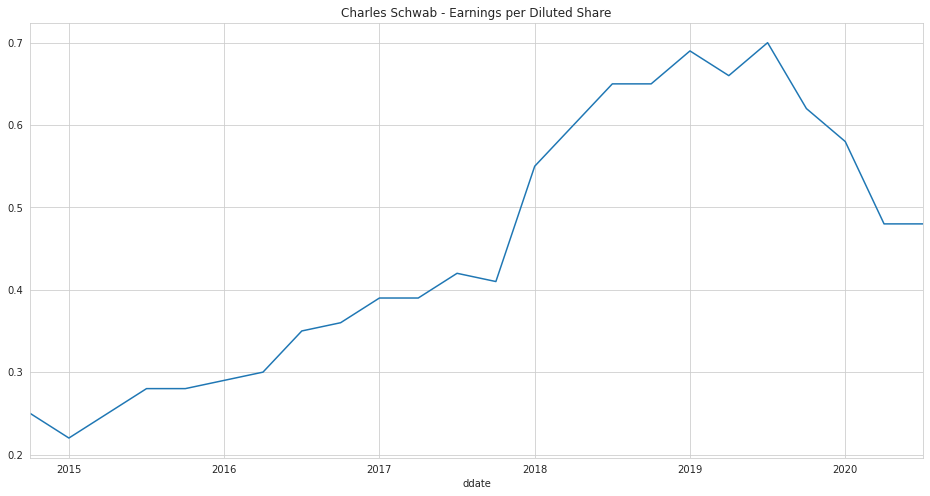

In [ ]:
# grab EPS from DataFrame
eps = schwab_numeric[(schwab_numeric['tag'] == 'EarningsPerShareDiluted') & (schwab_numeric['qtrs'] == 1)].drop(['tag', 'dimh'], axis=1)

# keep only the ones by the latest date
eps = eps.groupby('adsh').apply(lambda x: x.nlargest(n=1, columns='ddate')).drop('adsh', axis=1)

# just keep the values we want
eps = eps[['value', 'ddate']].set_index('ddate').squeeze().sort_index()

# plot
sns.set_style('whitegrid')
eps.plot(figsize=(16,8), title='Charles Schwab - Earnings per Diluted Share');

### P/E Ratio

We need stock prices to make this one. We can get those using pandas and yahoo finance. Pandas-datareader's yahoo finance abilities are not working for some reason.

In [ ]:
symbol = 'SCHW'
schwab_price = pd.read_csv('https://query1.finance.yahoo.com/v7/finance/download/SCHW?period1=1419984000&period2=1601424000&interval=1d&events=history&includeAdjustedClose=true')
schwab_price.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2014-12-31,30.490000,30.670000,30.180000,30.190001,28.038145,2915800
1,2015-01-02,30.410000,30.570000,29.809999,30.219999,28.066006,4537600
2,2015-01-05,29.969999,30.000000,29.129999,29.209999,27.127998,5931400
3,2015-01-06,29.209999,29.280001,27.920000,28.139999,26.134260,9825000
4,2015-01-07,28.459999,28.700001,28.219999,28.690001,26.645060,7966100


In [ ]:
schwab_price['Date'] = pd.to_datetime(schwab_price['Date'])
schwab_price = schwab_price.set_index('Date')
schwab_price.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2014-12-31,30.490000,30.670000,30.180000,30.190001,28.038145,2915800
2015-01-02,30.410000,30.570000,29.809999,30.219999,28.066006,4537600
2015-01-05,29.969999,30.000000,29.129999,29.209999,27.127998,5931400
2015-01-06,29.209999,29.280001,27.920000,28.139999,26.134260,9825000
2015-01-07,28.459999,28.700001,28.219999,28.690001,26.645060,7966100


In [ ]:
schwab_price.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1447 entries, 2014-12-31 to 2020-09-29
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Open       1447 non-null   float64
 1   High       1447 non-null   float64
 2   Low        1447 non-null   float64
 3   Close      1447 non-null   float64
 4   Adj Close  1447 non-null   float64
 5   Volume     1447 non-null   int64  
dtypes: float64(5), int64(1)
memory usage: 79.1 KB


In [ ]:
pe_ratio = schwab_price['Adj Close'].to_frame('price').join(eps.to_frame('eps'))
pe_ratio = pe_ratio.fillna(method='ffill').dropna()
pe_ratio['pe_ratio'] = pe_ratio['price'].div(pe_ratio['eps'])
pe_ratio.head()

,price,eps,pe_ratio
Date,,,
2014-12-31,28.038145,0.25,112.152580
2015-01-02,28.066006,0.25,112.264024
2015-01-05,27.127998,0.25,108.511992
2015-01-06,26.134260,0.25,104.537040
2015-01-07,26.645060,0.25,106.580240


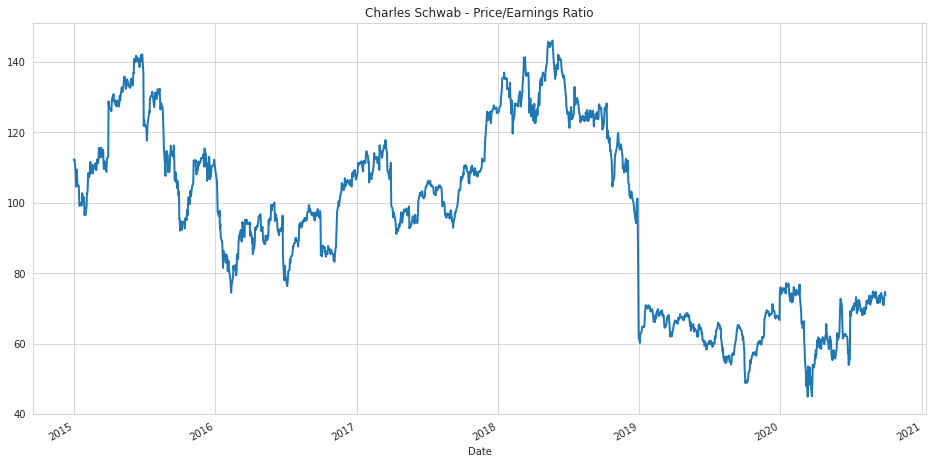

In [ ]:
# plot P/E ratio
pe_ratio['pe_ratio'].plot(figsize=(16,8), title='Charles Schwab - Price/Earnings Ratio', lw=2);

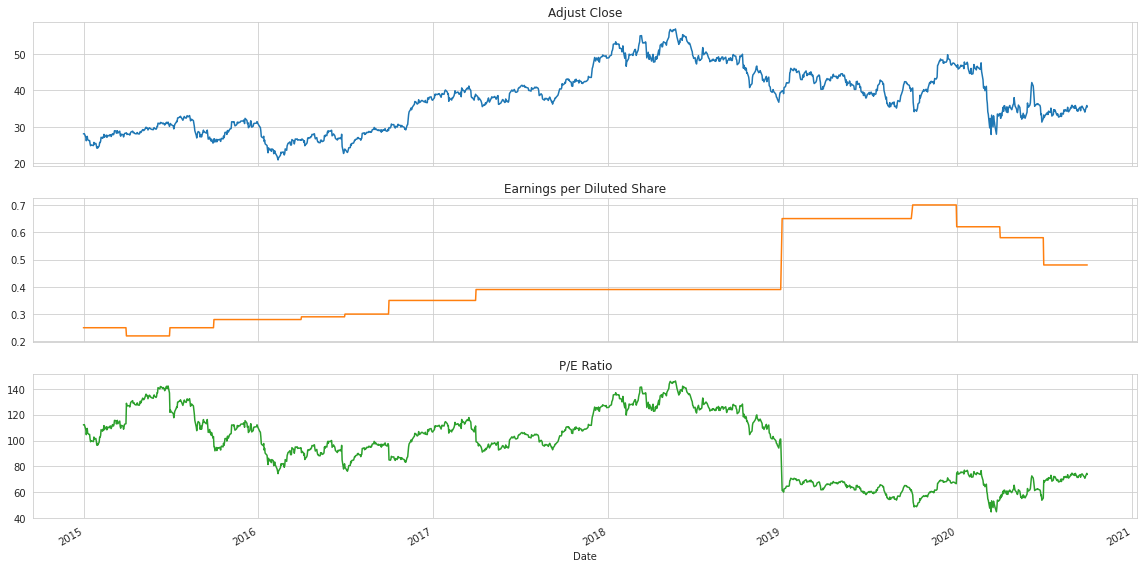

In [ ]:
# make one plot with price, EPS, and P/E
axes = pe_ratio.plot(subplots=True, figsize=(16,8), legend=False)
axes[0].set_title('Adjust Close')
axes[1].set_title('Earnings per Diluted Share')
axes[2].set_title('P/E Ratio')
plt.tight_layout();

# Other stuff in there

In [ ]:
schwab_numeric['tag'].value_counts()

AvailableForSaleSecuritiesDebtSecurities                            2037
HeldToMaturitySecuritiesFairValue                                   1826
LoansAndLeasesReceivableConsumerRealEstate                          1310
LoansReceivableFairValueDisclosure                                  1020
FinancingReceivableRecordedInvestmentPastDue                         830
                                                                    ... 
MortgageLoansOnRealEstateInterestRate                                  1
PreferredStockDividendPaymentVariableRate                              1
ProceedsFromPrincipalRepaymentsOnLoansAndLeasesHeldForInvestment       1
DebtConversionConvertedInstrumentAmount1                               1
BusinessAcquisitionEquityInterestNumberOfSharesHeld                    1
Name: tag, Length: 856, dtype: int64

## Dividends?

In [ ]:
dividends = schwab_numeric.loc[[bool(re.search(r".*Pay.*Div.*", tag)) for tag in schwab_numeric['tag']], ['tag', 'ddate', 'value']]
dividends['tag'].unique()

array(['PaymentsOfDividends',
       'ShareBasedCompensationArrangementByShareBasedPaymentAwardFairValueAssumptionsExpectedDividendRate'],
      dtype=object)

In [ ]:
dividends = dividends[dividends['tag'] == 'PaymentsOfDividends'].drop('tag', axis=1).groupby('ddate').mean()
dividends.info()

KeyError: ignored

In [ ]:
shares = schwab_numeric.loc[schwab_numeric['tag'] == 'WeightedAverageNumberOfDilutedSharesOutstanding', ['ddate', 'value']].drop_duplicates().groupby('ddate').mean()
div_per_share = dividends.div(shares).dropna()
div_per_share.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 29 entries, 2012-12-31 to 2020-09-30
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   value   29 non-null     float64
dtypes: float64(1)
memory usage: 464.0 bytes


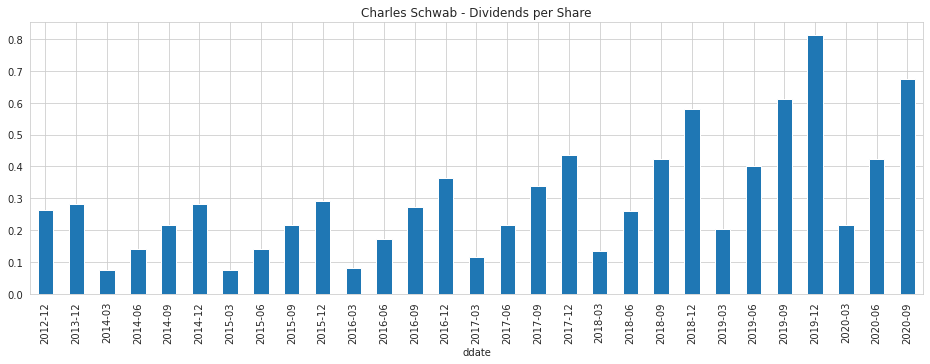

In [ ]:
# plot dividends
ax = div_per_share.plot.bar(figsize=(16,5), title='Charles Schwab - Dividends per Share', legend=False)
ax.xaxis.set_major_formatter(mticker.FixedFormatter(div_per_share.index.strftime('%Y-%m')))